In [43]:

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk
from PIL import Image
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk import ngrams 
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from operator import itemgetter
nltk.download('stopwords')
from lxml import etree
from gensim.models import Word2Vec
import glob, csv
import pandas as pd
import seaborn as sns
import re
from sklearn.decomposition import PCA
from gensim.scripts import word2vec2tensor
from itertools import combinations

stop_words = stopwords.words('english')

def remove_stopwords(data):
    stop_words.extend(['thus', 'thereof', 'thence', 'thee', 'therein', 
                    'wherein', 'whereby', 'whereas', 'whereof', 'also', 'us', 'upon', 
                    'would', 'within', 'indeed', 'become', 'viz', 'per', 'anno', 
                    'whilst', 'shall','may','unto','say','day','one','make',
                    'two','come','time','place', 'thou', 'thy', 'afterward'])
    
    return [[word for word in simple_preprocess(str(doc))
            if word not in stop_words] for doc in data]

[nltk_data] Downloading package stopwords to /home/yz535/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
texts = []
textnames = []
folder = '/srv/data/newEPTuningCleaner'
for file in os.listdir(folder):
    path = os.path.join(folder,file)
    f = open(path,'r')
    data = f.readlines()[0]
    texts.append(data)
    name = file.split('.')[0]
    textnames.append(name)
    f.close()

# list of lists of strings, each text broken up into individual token strings
tokenized = []
for text in texts:
    words = []
    text = text.split(' ')
    #tokenize roughly by white space, can update later
    cleaned = remove_stopwords(text)
    for c in cleaned:
        if len(c) != 0:
            words.append(c[0].lower())
    tokenized.append(words)



In [15]:
bigrammodel = Phrases(tokenized, min_count = 3, threshold=20)

In [16]:

all_sentences = []
for t in textnames:
    textindex = textnames.index(t)
    all_sentences.append(bigrammodel[tokenized[textindex]])

In [21]:
all_sentences

[['relation',
  'state',
  'religion',
  'hope',
  'policy',
  'frame',
  'maintain',
  'several',
  'state',
  'western',
  'world',
  'finish',
  'intend',
  'course',
  'travel',
  'cast',
  'short',
  'account',
  'labour',
  'endeavour',
  'brief',
  'relate',
  'observe',
  'religion',
  'chief',
  'employ',
  'first',
  'principal',
  'design',
  'view',
  'state',
  'western',
  'world',
  'divide_faction',
  'profession',
  'difference',
  'faith',
  'exercise',
  'religion',
  'government',
  'ecclesiastical',
  'life',
  'conversation',
  'virtue',
  'kind',
  'eminent',
  'eminent',
  'defect',
  'moreover',
  'term',
  'opposition',
  'correspondency',
  'stand',
  'probability',
  'policy',
  'hope',
  'jealousy',
  'find',
  'advance',
  'final',
  'possibility',
  'good',
  'mean',
  'unite',
  'leastwise',
  'several',
  'branch',
  'reform',
  'professor',
  'unity',
  'universal',
  'desire',
  'hope',
  'bitterness',
  'mind',
  'equality',
  'force',
  'leave',
  '

In [45]:
word2vec = Word2Vec(all_sentences, min_count=2, window=4)
word2vec.wv.save_word2vec_format('/srv/data/tensor/EPBigram.model')
word2vec.save('/srv/data/embedmodels/EPBigram.model')

In [42]:
print(word2vec.wv.most_similar("merchandize"))

[('history', 0.99955153465271), ('serve', 0.9995367527008057), ('art', 0.9995356202125549), ('plantation', 0.9995291829109192), ('occasion', 0.9995259642601013), ('want', 0.9995254278182983), ('sword', 0.9995245933532715), ('state', 0.9995223879814148), ('proceed', 0.9995222687721252), ('better', 0.9995222687721252)]


In [37]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(word2vec.wv.get_normed_vectors())
pca_df = pd.DataFrame(pca_results, index=word2vec.wv.key_to_index, columns=["pc1","pc2"])
pca_df

,pc1,pc2
great,-0.709503,-0.000741
man,-0.709375,0.004585
king,-0.709320,0.000986
call,-0.709318,-0.003210
ship,-0.709116,0.005561
...,...,...
vologeses,0.247039,0.086328
heredotus,0.390935,0.043033
scythic,0.204894,0.202797
herule,0.297957,-0.028313


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

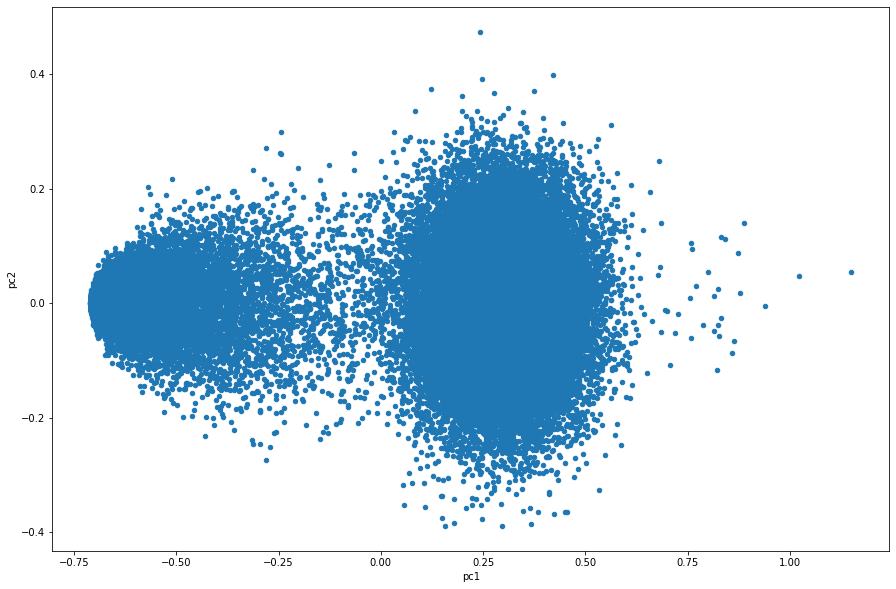

In [38]:
pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10))

In [39]:

word2vec2tensor.word2vec2tensor('/srv/data/tensor/EPBigram.model', '/srv/data/tensor/TSV/EPbigram', binary=False)

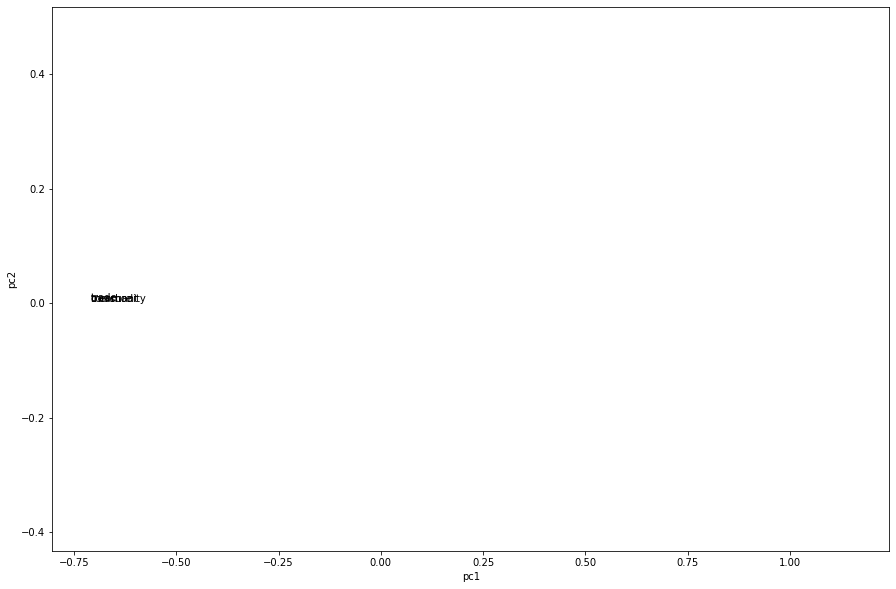

In [40]:
ax = pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10),alpha=0)
for txt in pca_df.index:
    if txt in ["trade", "treasure", "commodity", "merchant"]:
        x = pca_df.pc1.loc[txt]
        y = pca_df.pc2.loc[txt]
        ax.annotate(txt, (x,y))
plt.show()

In [82]:
#Heatmap
vectors = word2vec.wv

def cosine_similarity(pair):

    '''
    Word2Vec.wv.similarity(word1,word2)
    '''
    word1, word2 = pair

    sim = vectors.similarity(word1,word2)

    return sim


def generate_heatmap_matrix(lexicon):

    pairs = list(combinations(lexicon, 2))

    sim_scores = [cosine_similarity(pair) for pair in pairs]

    sim_df = pd.DataFrame({'pair': pairs, 'similarity': sim_scores})

    sim_df['word1'] = sim_df['pair'].apply(lambda x: lexicon.index(x[0]))
    sim_df['word2'] = sim_df['pair'].apply(lambda x: lexicon.index(x[1]))

    sim_df['pair'] = list(zip(sim_df.word1, sim_df.word2, sim_df.similarity))

    df_hm = pd.DataFrame({'word1': range(len(lexicon)),
                          'word2': range(len(lexicon)),
                          'similarity': pd.Series(np.ones(len(lexicon)))})

    df_hm = df_hm.pivot(index='word1', columns='word2').fillna(0)

    for row, col, similarity in sim_df.pair:

        df_hm.iloc[col,row] = similarity

    return df_hm


def plot_heatmap(lexicon):

    df_hm = generate_heatmap_matrix(lexicon)

    mask = np.zeros_like(df_hm)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(df_hm,
                mask = mask,
                xticklabels = lexicon,
                yticklabels = lexicon,
                cmap="YlGnBu")
    plt.xlabel('word 1')
    plt.ylabel('word 2')
    plt.title(f'Similarity Between Word-Pairs')
    plt.show()





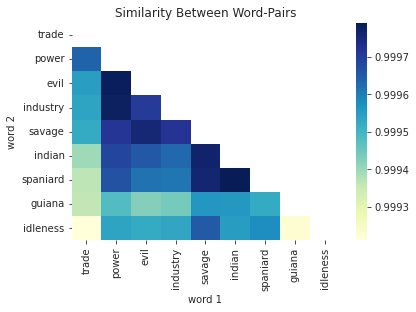

In [83]:
lexicon = ['trade','power','evil','industry', 'savage', 'indian', 'spaniard', 'guiana', 'idleness']

plot_heatmap(lexicon)